In [35]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Get Dataframe, features and target

In [36]:
df = pd.read_csv('games_data.csv', encoding = 'unicode_escape', index_col='id').drop_duplicates()
df.head(5)

C:\Users\micka\AppData\Local\Temp\ipykernel_4676\1462289221.py:1: DtypeWarning: Columns (0,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('games_data.csv', encoding = 'unicode_escape', index_col='id').drop_duplicates()


,title,release_date,developer,publisher,genres,multiplayer_or_singleplayer,price,dc_price,overall_review,detailed_review,reviews,percent_positive,win_support,mac_support,lin_support
id,,,,,,,,,,,,,,,
0,Counter-Strike: Global Offensive,2012-08-21,Valve;Hidden Path Entertainment,Valve,Action;Free to Play,Multi-player;Steam Achievements;Full controlle...,Free to play,Free to play,Positive,Very Positive,6774812,88%,1,1.0,1.0
1,Dota 2,2013-07-09,Valve,Valve,Action;Free to Play;Strategy,Multi-player;Co-op;Steam Trading Cards;Steam W...,Free to play,Free to play,Positive,Very Positive,1885261,82%,1,1.0,1.0
2,"Warhammer 40,000: Darktide",NaN,NaN,NaN,NaN,NaN,"2,199","2,199",Positive,Mostly Positive,26092,72%,1,0.0,0.0
3,Call of Duty®: Modern Warfare® II,NaN,NaN,NaN,NaN,NaN,"4,999","4,999",Mixed,Mixed,215969,64%,1,0.0,0.0
4,Apex Legends,NaN,NaN,NaN,NaN,NaN,Free to play,Free to play,Positive,Very Positive,539297,85%,1,0.0,0.0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66923 entries, 0 to 73343.0
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   title                        66922 non-null  object 
 1   release_date                 22774 non-null  object 
 2   developer                    22774 non-null  object 
 3   publisher                    22774 non-null  object 
 4   genres                       22774 non-null  object 
 5   multiplayer_or_singleplayer  22774 non-null  object 
 6   price                        66921 non-null  object 
 7   dc_price                     66921 non-null  object 
 8   overall_review               36864 non-null  object 
 9   detailed_review              36857 non-null  object 
 10  reviews                      36857 non-null  object 
 11  percent_positive             36857 non-null  object 
 12  win_support                  66918 non-null  object 
 13  mac_support        

In [38]:
# Transformer les valeurs numériques en float, drop les jeux "Free to play"

df = df.iloc[:, [6,7]][df['price'] != 'Free to play']
df.iloc[:,[0,1]] = df.iloc[:,[0,1]].apply(pd.to_numeric, errors='coerce')
df[['price', 'dc_price']] *= 0.011
df.dropna(inplace=True)
df = df[df['price'] > df['dc_price']]
df = df.apply(pd.to_numeric, errors='coerce')


In [39]:
df.info

<bound method DataFrame.info of           price  dc_price
id                       
23       10.989     4.389
63        8.349     4.169
149       9.889     6.622
181       7.689     1.914
216       6.578     1.309
...         ...       ...
67097.0   0.462     0.231
67576.0   0.935     0.462
69891.0   2.200     1.980
70795.0   4.400     3.520
73068.0   1.155     0.858

[2570 rows x 2 columns]>

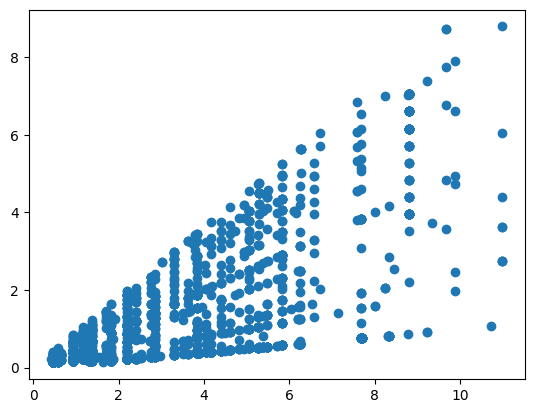

In [40]:
plt.scatter(df['price'], df['dc_price'])

In [41]:
df.isnull().sum() / df.count().max() * 100


price       0.0
dc_price    0.0
dtype: float64

---

In [42]:
from sklearn.pipeline import make_pipeline

def create_pipeline(model=LinearRegression()):
    num_pipeline = Pipeline(
        [
        ('imputer', SimpleImputer(strategy="median")),
        ('minmax_scaler', MinMaxScaler())
        ]
    )
    cat_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')
    preprocessor = ColumnTransformer([
        ('num_transformer', num_pipeline, make_column_selector(dtype_include = np.number)),
        ('cat_transformer', cat_transformer, make_column_selector(dtype_exclude = np.number))
        ])
    pipeline_workflow = make_pipeline(preprocessor, model)
    return pipeline_workflow


### Loop and score for each strategie, scoring method, model used

In [43]:
# X = df.drop(columns=['Discount_Price', 'Nb_reviews', 'Positive_review_pecentage'])
X = df[['price']]
y = df['dc_price']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
pipeline_workflow = create_pipeline()
pipeline_workflow.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021CBEE13940>),
                                                 ('cat_transformer',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021CBEE13C40>)])),
                ('linearregression', LinearRegression())])

In [45]:
print(f"score de prédiction: {pipeline_workflow.score(X_test, y_test)}")
print(f"cross val score: {cross_val_score(pipeline_workflow, X_train, y_train, cv=5, scoring='r2').mean()}")

score de prédiction: 0.5454045371348198
cross val score: 0.5001345360106517


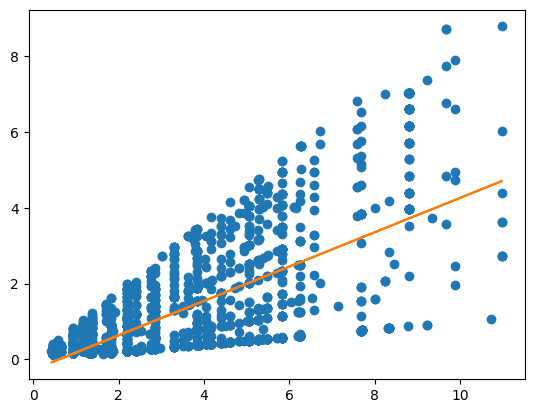

In [50]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train)  # Add a column of 1s to X
model = sm.OLS(y_train, X_train).fit()

# Get the a and b parameters
a = model.params[1]
b = model.params[0]

plt.plot(X_train, a * X_train + b)
plt.scatter(df['price'], df['dc_price'])
plt.show()

---

# Pickle the model

In [ ]:
import pickle
pickle.dump(pipeline_workflow, open('pipeline.pkl', 'wb'))

In [51]:
# Test

pickled_model = pickle.load(open('pipeline.pkl', 'rb'))
pickled_model.score(X_test, y_test)

0.5463482981045359

---